Import the required libraries

In [1]:
!pip install albumentations==0.4.6

In [2]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import random, os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

### Discriminator Model

In this part of the notebook the blocks which are the building blocks of the generator and discriminator modules are defined. These blocks are defined so that they can down sample and also up sample the information which are fed to them. These informations are indeed the photos and random data also known az Z vector. The discriminator module, the input vector would go through the convolutional blocks that try to extract the most important part of data which is actually the pictures generated by the generator or real data. As the Block module is capble of doing down sampling and also up sampling and considering the purpose of discriminator module, the down sampling features is being used here. 

In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1, padding_mode='reflect', bias=True),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(.2)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=features[0], 
                kernel_size=4,
                stride=2,
                padding=1, 
                padding_mode='reflect'
            ),
            nn.LeakyReLU(.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                 out_channels=1, 
                 kernel_size=4,
                  stride=1, 
                  padding=1, 
                  padding_mode='reflect'
                  )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = torch.sigmoid(self.model(x))
        return x

### Generator Model

The generator module is being implemented in this part. This module gets the pictures from one domain as the input and tries to translate the image to the other domain using three layers of blocks. the first set of blocks are used to down sample the data from the input image to extract the most important features in the image. The process being done in the second layer of this structur is actually analogous to what the fully connected layers do in simpler networks. They get the input resulted from the previous layer and try to pass them through some residual blocks to extract the most important features that can be captures in this stage. 

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sample=True, use_activation=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs) if down_sample else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_activation else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down_sample=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down_sample=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.final = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        x = torch.tanh(self.final(x))
        return x

### DataSet Loader

The dataset is being loaded from Kaggle and after that the file structure is being modified to suit our purpose for training and using it.

In [5]:
! pip install -q kaggle
from google.colab import files 
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d balraj98/monet2photo

 98% 285M/291M [00:03<00:00, 105MB/s] 
100% 291M/291M [00:03<00:00, 92.8MB/s]


In [ ]:
!unzip monet2photo.zip

In [8]:
!mkdir -p data/train data/test
!mv testA data/test/monets
!mv testB data/test/photos
!mv trainA data/train/monets
!mv trainB data/train/photos

### Config

All the hyper parameters and the constant values are being defined here.

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/test"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 5
SCALE.5
TRANSLATE=.5
LAMBDA_CYCLE = 10
NUM_WORKERS = 2
NUM_EPOCHS = 10

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[TRANSLATE, TRANSLATE, TRANSLATE], std=[SCALE, SCALE, SCALE], max_pixel_value=255),
        ToTensorV2(),
     ],
    additional_targets={"photo": "monet"},
)

### Utils

Functions which are called for saving the weights and check points and also loading them are defined in this section. In addition, the last method defined in this part is for reproducability of the results and seeding all the random variables. 

In [11]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
class MonetPhotoDataset(Dataset):
    def __init__(self, photo_root_dir, monet_root_dir, transform=None):
        self.photo_root_dir = photo_root_dir
        self.monet_root_dir = monet_root_dir
        self.transform = transform

        self.photo_images = os.listdir(photo_root_dir)
        self.monet_images = os.listdir(monet_root_dir)
        self.length_dataset = max(len(self.photo_images), len(self.monet_images))
        self.photo_len = len(self.photo_images)
        self.monet_len = len(self.monet_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        photo_img = self.photo_images[index % self.photo_len]
        monet_img = self.monet_images[index % self.monet_len]

        monet_path = os.path.join(self.monet_root_dir, monet_img)
        photo_path = os.path.join(self.photo_root_dir, photo_img)

        monet_img = np.array(Image.open(monet_path).convert("RGB"))
        photo_img = np.array(Image.open(photo_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(monet=monet_img, photo=photo_img)
            monet_img = augmentations["monet"]
            photo_img = augmentations["photo"]

        return monet_img, photo_img  


### Train

In this part, the train function and the function to call it are defined. In the train function, the photo and the monet are being input to the network and the fake pictures associated with them are generated by the generators. In the next step, these real and fake pictures are fed into the discriminators defined at the last layer of the network to check whether they're real or fake. 

In the next section, the losses which are related to the generator module are defined. These losses as follows: 
The first loss which is the regular adversarial loss tries to fool the discriminator by making it accept the fake picture as being a real one. The second loss which is the cycle loss is designated to penalize the model for generating pictures which are too different from the source domain picture. This way, only the features and details not different from the two domains will change and not all the non necessary features and details that may not be changed during the transition from domain A to domain B. Finally, the last loss value's purpuse is to make sure that the generator that should generate pictures in domain D, if given a picture which is already in domain D, will output the input and do not modify it. 

In the main function, all the necessary modules are instantiated and used to be able to iterate over the dataset by using loader functions and train the model at hand.

In [20]:
loss_vector = []

def train_fn(disc_photo, disc_monet, gen_monet, gen_photo, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    photo_reals = 0
    photo_fakes = 0
    loop = tqdm(loader, leave=True)
    epoch_loss = []

    for idx, (monet, photo) in enumerate(loop):
        monet = monet.to(DEVICE)
        photo = photo.to(DEVICE)


        with torch.cuda.amp.autocast():
            fake_photo = gen_photo(monet)
            disc_photo_real = disc_photo(photo)
            disc_photo_fake = disc_photo(fake_photo.detach())
            photo_reals += disc_photo_real.mean().item()
            photo_fakes += disc_photo_fake.mean().item()
            disc_photo_real_loss = mse(disc_photo_real, torch.ones_like(disc_photo_real))
            disc_photo_fake_loss = mse(disc_photo_fake, torch.zeros_like(disc_photo_fake))
            disc_photo_loss = disc_photo_real_loss + disc_photo_fake_loss

            fake_monet = gen_monet(photo)
            disc_monet_real = disc_monet(monet)
            disc_monet_fake = disc_monet(fake_monet.detach())
            disc_monet_real_loss = mse(disc_monet_real, torch.ones_like(disc_monet_real))
            disc_monet_fake_loss = mse(disc_monet_fake, torch.zeros_like(disc_monet_fake))
            disc_monet_loss = disc_monet_real_loss + disc_monet_fake_loss

        
            disc_loss = (disc_photo_loss + disc_monet_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        
        with torch.cuda.amp.autocast():
            
            disc_photo_fake = disc_photo(fake_photo)
            disc_monet_fake = disc_monet(fake_monet)
            loss_gen_photo = mse(disc_photo_fake, torch.ones_like(disc_photo_fake))
            loss_gen_monet = mse(disc_monet_fake, torch.ones_like(disc_monet_fake))

            
            cycle_monet = gen_monet(fake_photo)
            cycle_photo = gen_photo(fake_monet)
            cycle_monet_loss = l1(monet, cycle_monet)
            cycle_photo_loss = l1(photo, cycle_photo)

            
            identity_monet = gen_monet(monet)
            identity_photo = gen_photo(photo)
            identity_monet_loss = l1(monet, identity_monet)
            identity_photo_loss = l1(photo, identity_photo)

            
            G_loss = (
                loss_gen_monet
                + loss_gen_photo
                + cycle_monet_loss * LAMBDA_CYCLE
                + cycle_photo_loss * LAMBDA_CYCLE
                + identity_photo_loss * LAMBDA_IDENTITY
                + identity_monet_loss * LAMBDA_IDENTITY
            )
        epoch_loss.append(G_loss.item())
        loss_vector.append(np.mean(epoch_loss))

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_photo*SCALE+TRANSLATE, f"saved_images/photo_{idx}.png")
            save_image(fake_monet*SCALE+TRANSLATE, f"saved_images/monet_{idx}.png")

        loop.set_postfix(H_real=photo_reals/(idx+1), H_fake=photo_fakes/(idx+1))

    
    print(loss_vector)
    



def main():
    disc_photo = Discriminator(in_channels=3).to(DEVICE)
    disc_monet = Discriminator(in_channels=3).to(DEVICE)
    gen_monet = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_photo = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    opt_disc = optim.Adam(
        list(disc_photo.parameters()) + list(disc_monet.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_monet.parameters()) + list(gen_photo.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    


    dataset = MonetPhotoDataset(
        photo_root_dir=TRAIN_DIR+"/photos", monet_root_dir=TRAIN_DIR+"/monets", transform=transforms
    )
    val_dataset = MonetPhotoDataset(
       photo_root_dir=VAL_DIR+"/photos", monet_root_dir=VAL_DIR+"/monets", transform=transforms
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_photo, disc_monet, gen_monet, gen_photo, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

In [ ]:
main()

Text(0, 0.5, 'loss')

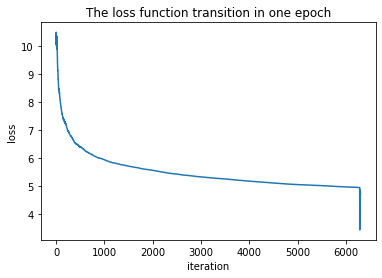

In [30]:
plt.plot(loss_vector)
plt.title('The loss function transition in one epoch')
plt.xlabel('iteration')
plt.ylabel('loss')